In [1]:
from room import *
from ray_tracing import RayTracingSolver
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import cProfile
import pstats
import io

dim = 5

room = Room(reflection_eff=0.8, dimension=3, bounds={'x': (-dim, dim), 'y': (-dim, dim), 'z': (-dim, dim)})
room.add_surface(Ellipsoid(center=[0.5, -5, 0.2], radii=[2, 2, 2], reflection_eff=0.8))
room.add_surface(Ellipsoid(center=[2, 2, 2], radii=[2, 3, 3], reflection_eff=0.8))
sources = [Source(position=[0, 0, 0], power=10, num_rays=int(10000/(10/dim)**3), dimension=3)]
receivers = [Receiver(position=[0, -2, -2], radii=[0.1, 0.1, 0.1], type="virtual"), 
             Receiver(position=[0, 2, 2], radii=[0.1, 0.1, 0.1], type="virtual"), 
             Receiver(position=[0, 2, -2], radii=[0.1, 0.1, 0.1], type="virtual"), 
                Receiver(position=[0, -2, 2], radii=[0.1, 0.1, 0.1], type="virtual")]
solver = RayTracingSolver(room, sources, receivers, max_time=10.0, energy_threshold=1e-10)

pr = cProfile.Profile()
pr.enable()

solution = solver.solve()

pr.disable()
s = io.StringIO()
ps = pstats.Stats(pr, stream=s).sort_stats('cumulative')
ps.print_stats()
print(s.getvalue())

100%|██████████| 1250/1250 [00:05<00:00, 229.39it/s]

         10478321 function calls (10334128 primitive calls) in 5.476 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        2    0.000    0.000    5.477    2.739 /Users/andrewzchen/opt/anaconda3/envs/physics113/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3541(run_code)
    282/2    0.001    0.000    5.477    2.739 {built-in method builtins.exec}
        1    0.267    0.267    5.477    5.477 /Users/andrewzchen/S-Junior/Spring Quarter/PHYSICS 113/Final Project/ray_tracing.py:141(solve)
   352476    0.511    0.000    2.074    0.000 /Users/andrewzchen/S-Junior/Spring Quarter/PHYSICS 113/Final Project/room.py:54(intersect)
   352476    0.613    0.000    1.696    0.000 /Users/andrewzchen/S-Junior/Spring Quarter/PHYSICS 113/Final Project/room.py:117(intersect)
        2    0.000    0.000    1.540    0.770 /Users/andrewzchen/opt/anaconda3/envs/physics113/lib/python3.10/site-packages/numba/core/dispatcher.py:344

In [3]:
solver.plot(show_solution=True, num_rays_show=5, opacity=True, saveto="vis_example")

/Users/andrewzchen/S-Junior/Spring Quarter/PHYSICS 113/Final Project/ray_tracing.py:197: RuntimeWarning:

invalid value encountered in divide



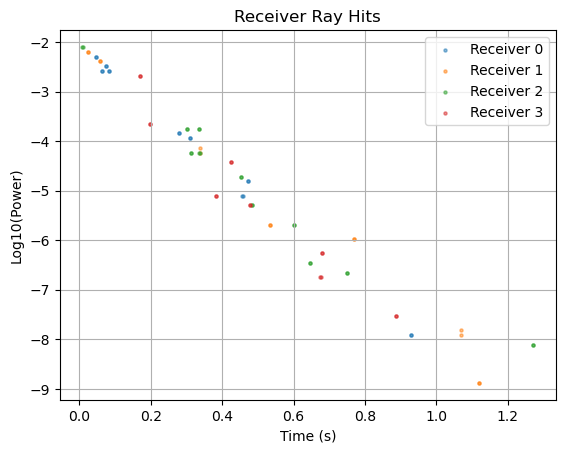

In [4]:
hits_list = [np.array(receiver.hits) for receiver in solution.receivers]
# hits_list = [solution.aggeregate_hits()]

idx = 0
for hits in hits_list:
    if hits.size > 0 and hits.shape[1] >= 2:
        plt.scatter(hits[:, 0], np.log10(hits[:, 1]), label=f"Receiver {idx}", s=5, alpha=0.5)
    idx += 1
plt.xlabel('Time (s)')
plt.ylabel('Log10(Power)')
plt.legend()
plt.grid()
plt.title('Receiver Ray Hits')
plt.show()


In [26]:
solution.aggregate_hits().shape

(174, 2)

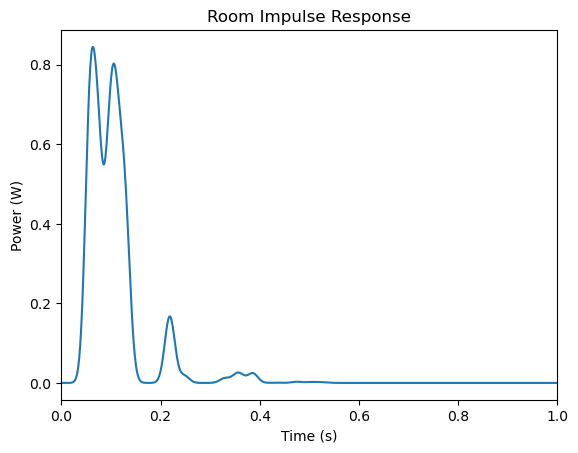

In [5]:

def gaussian(mu, sigma):
    return lambda t: np.exp(-((t - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

responses = solution.get_responses(kernel_func=gaussian(mu=0.05, sigma=0.01), aggregate=True)

for response in responses:
    plt.figure()
    plt.plot(response[0], response[1])
    plt.xlabel('Time (s)')
    plt.ylabel('Power (W)')
    plt.xlim(0, 1)
    plt.title('Room Impulse Response')
    plt.show()

In [14]:
def gaussian(mu, sigma):
    return lambda t: np.exp(-((t - mu) ** 2) / (2 * sigma ** 2)) / (sigma * np.sqrt(2 * np.pi))

print(solution.get_RT60(kernel_func=None, method="threshold", aggregate=True), 
      solution.get_RT60(kernel_func=None, method="schroeder", aggregate=True), 
      solution.get_RT60(kernel_func=gaussian(mu=1, sigma=0.01), method="schroeder", aggregate=True)
)

[np.float64(1.0661557794171428)] [np.float64(0.8874295301470684)] [np.float64(0.8959999999999999)]


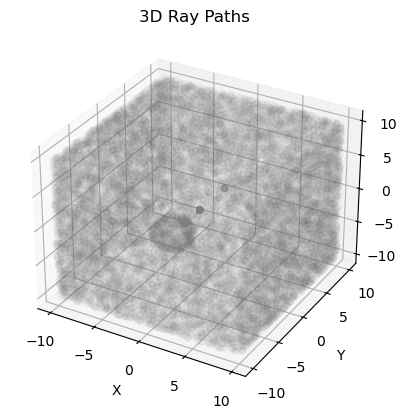

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for ray in solution.rays[::10]:
    path = np.array(ray.path)
    ax.scatter(path[:, 0], path[:, 1], path[:, 2], alpha=0.03, c="gray")

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Ray Paths')
plt.show()